In [ ]:
# Copyright © 2020, Johan Vonk
# SPDX-License-Identifier: MIT

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import paho.mqtt.client as mqtt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow_addons as tfa

In [4]:
DISTANCE=1.28
df=pd.read_csv('pact_20200703T210016.csv')
df['POWER']=10**((11.5511+df['TX POWER']-df['RSSI'])/20)
df['RADIATION']=0.234897256+0.732700955*np.cos(np.pi/12*(((pd.to_datetime(df['TIMESTAMP'])-pd.Timestamp('13:13:02'))/pd.Timedelta(hours=1)).mod(24)))
df['BOOLDISTANCE']=(df['DISTANCE']<DISTANCE).astype(int)

In [197]:
samples=df.sample(frac=1).groupby(['DISTANCE','BOOLDISTANCE']).apply(lambda x: pd.DataFrame({**{'POWER':x['POWER']},**{i:x['POWER'].shift(i).iloc[10:] for i in range(0,10)}}).dropna().sample(n=10000)).reset_index(level=2,drop=True).reset_index()

In [198]:
samples

,DISTANCE,BOOLDISTANCE,POWER,0,1,2,3,4,5,6,7,8,9
0,0.523414,1,0.846360,0.846360,0.754319,0.599177,0.754319,0.754319,0.754319,0.672287,0.599177,0.754319,0.599177
1,0.523414,1,0.672287,0.672287,0.754319,0.672287,0.599177,0.672287,0.754319,0.672287,0.754319,0.599177,0.754319
2,0.523414,1,0.672287,0.672287,0.672287,0.672287,0.754319,0.754319,0.672287,0.754319,0.599177,0.672287,9.496313
3,0.523414,1,0.599177,0.599177,0.672287,0.754319,0.672287,0.754319,0.754319,0.672287,0.599177,0.754319,0.599177
4,0.523414,1,0.754319,0.754319,0.599177,0.846360,0.754319,0.672287,0.754319,0.534017,0.672287,0.672287,0.672287
...,...,...,...,...,...,...,...,...,...,...,...,...,...
209995,2.413143,0,0.949631,0.949631,1.065504,1.065504,1.195515,1.195515,0.949631,0.949631,1.065504,1.065504,1.341390
209996,2.413143,0,1.341390,1.341390,1.195515,1.065504,1.195515,1.195515,1.065504,1.065504,1.195515,0.949631,1.505064
209997,2.413143,0,1.195515,1.195515,0.949631,1.195515,1.505064,1.195515,0.949631,0.949631,1.195515,3.002998,1.195515
209998,2.413143,0,0.949631,0.949631,1.065504,1.341390,1.195515,1.341390,1.341390,1.341390,1.065504,1.341390,1.341390


In [199]:
X=samples.loc[:,['POWER']+list(range(10))]
y=np.ravel(samples['BOOLDISTANCE'])

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [201]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [202]:
model = Sequential()
model.add(Dense(8, kernel_initializer='normal', activation='swish', input_shape=(11,)))
model.add(Dropout(0.2))
model.add(Dense(8, kernel_initializer='normal', activation='swish'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['precision','binary_accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 8)                 96        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class LearningRateTracker(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self._data = []
    def on_epoch_end(self, batch, logs={}):
        self._data.append({
            'lr': K.eval(self.model.optimizer.lr),
        })

    def get_data(self):
        return self._data

In [203]:
history = model.fit(X_train, y_train, epochs=128, batch_size=32, verbose=0, callbacks=[LearningRateTracker(), tfa.callbacks.TQDMProgressBar(), tf.keras.callbacks.ReduceLROnPlateau(verbose=1,factor=0.3)], validation_data=(X_test, y_test))

Epoch 1/128



Epoch 2/128



Epoch 3/128



Epoch 4/128



Epoch 5/128



Epoch 6/128



Epoch 7/128



Epoch 8/128



Epoch 9/128



Epoch 10/128



Epoch 11/128



Epoch 12/128



Epoch 13/128



Epoch 14/128



Epoch 15/128



Epoch 16/128



Epoch 17/128



Epoch 18/128



Epoch 19/128



Epoch 20/128



Epoch 21/128



Epoch 22/128



Epoch 23/128



Epoch 24/128



Epoch 25/128



Epoch 26/128



Epoch 27/128



Epoch 28/128



Epoch 29/128



Epoch 30/128



Epoch 31/128



Epoch 32/128



Epoch 33/128



Epoch 34/128



Epoch 35/128



Epoch 36/128



Epoch 37/128



Epoch 38/128



Epoch 39/128



Epoch 40/128



Epoch 41/128



Epoch 42/128



Epoch 43/128



Epoch 44/128



Epoch 45/128



Epoch 46/128



Epoch 47/128



Epoch 48/128



Epoch 49/128



Epoch 50/128



Epoch 51/128



Epoch 52/128



Epoch 53/128



Epoch 54/128



Epoch 55/128



Epoch 56/128



Epoch 57/128



Epoch 58/128



Epoch 59/128



Epoch 60/128



Epoch 61/128



Epoch 62/128



Epoch 63/128



Epoch 64/128



Epoch 65/128



Epoch 66/128



Epoch 67/128



Epoch 68/128



Epoch 69/128



Epoch 70/128



Epoch 71/128



Epoch 72/128



Epoch 73/128



Epoch 74/128



Epoch 75/128



Epoch 76/128



Epoch 77/128



Epoch 78/128



Epoch 79/128



Epoch 80/128



Epoch 81/128



Epoch 82/128



Epoch 83/128



Epoch 84/128



Epoch 85/128



Epoch 86/128



Epoch 87/128



Epoch 88/128



Epoch 89/128



Epoch 90/128



Epoch 91/128



Epoch 92/128



Epoch 93/128



Epoch 94/128



Epoch 95/128



Epoch 96/128



Epoch 97/128



Epoch 98/128



Epoch 99/128



Epoch 100/128



Epoch 101/128



Epoch 102/128



Epoch 103/128



Epoch 104/128



Epoch 105/128



Epoch 106/128



Epoch 107/128



Epoch 108/128



Epoch 109/128



Epoch 110/128



Epoch 111/128



Epoch 112/128



Epoch 113/128



Epoch 114/128



Epoch 115/128



Epoch 116/128



Epoch 117/128



Epoch 118/128



Epoch 119/128



Epoch 120/128



Epoch 121/128



Epoch 122/128



Epoch 123/128



Epoch 124/128



Epoch 125/128



Epoch 126/128



Epoch 127/128



Epoch 128/128


In [204]:
model.save('model-rssi')

INFO:tensorflow:Assets written to: model-rssi\assets


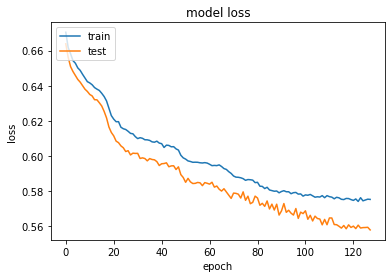

In [205]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [226]:
X_predict=scaler.transform(X)
samples['PREDICTION']=model.predict(X_predict, verbose=1)

6563/6563 [==============================] - 11s 2ms/step


In [209]:
y_predict=model.predict(X_test,verbose=1)

2166/2166 [==============================] - 4s 2ms/step


In [253]:
confusion_distance=df['BOOLDISTANCE'].mean()
graph_test=y
graph_predict=samples['PREDICTION']
print("ML model loss is {0:.5}.".format(tf.keras.losses.binary_crossentropy(graph_test,graph_predict).numpy()))
print("False positive rate is {0:.3%}.".format(tf.keras.metrics.FalsePositives(graph_test,graph_predict).numpy()))
print("True positive rate is {0:.3%}.".format(tf.keras.metrics.TruePositives(graph_test,graph_predict).numpy()))
sns.jointplot(x=graph_test, y=graph_predict, kind='hex')

ML model loss is 0.55732.


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [280]:
m=tf.keras.metrics.PrecisionAtRecall(0.8, num_thresholds=1)
m.update_state(graph_test,graph_predict)
m?

In [246]:
confusion_df

,0,1
0,90000,0
1,120000,0
